In [72]:
include("optimization_library.jl");
include("mplstyle.jl");

# Exercise 4.1

In [142]:
import DelimitedFiles
DF = DelimitedFiles;

We have given a mini shock absorber for scale cars which we want to characterize.

<img src="figures/Mini_Shocks.JPG" width="400">

Figure credit: By Avsar Aras - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=25687910

After applying a force on the absorber, we did a total of 30 measurements of its vertical position $p$ over time $t$. Negative values of $p$ mean that the shock absorber is compressed while positive values mean that it is expanded.

Due to the small scale of the shock absorbers and our limited measurement techniques, the data is influenced by statistical fluctuations within the measurement procedure.

We already split our 30 data points into 20 points for training and 10 points for testing.


In [143]:
# load training data
data = DF.readdlm("train_data.csv",',', Float64)
p_train = data[2,:]
t_train = data[1,:];

In [144]:
# load test data
data = DF.readdlm("test_data.csv",',', Float64)
p_test = data[2,:]
t_test = data[1,:];

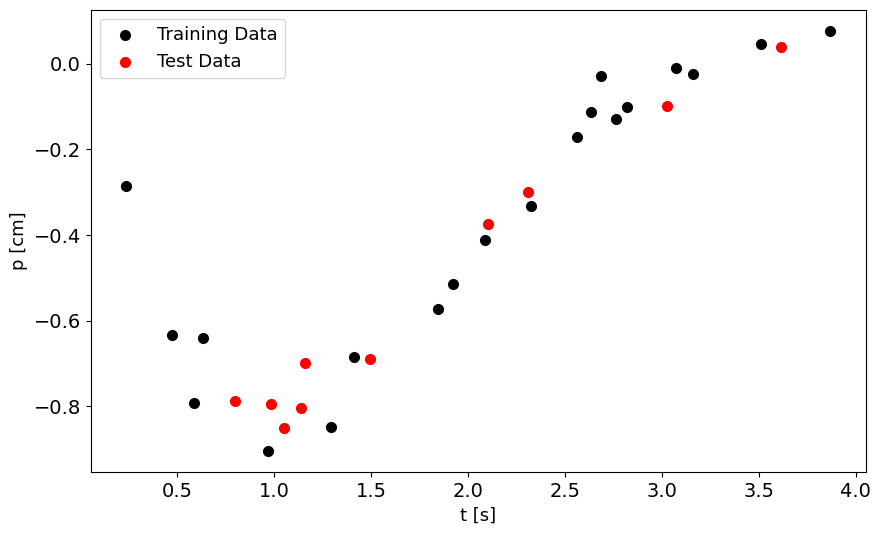

PyObject <matplotlib.legend.Legend object at 0x000001E5EB105330>

In [145]:
# Visualize the data points
fig = figure(figsize= (10,6))
fontsize = 13
scatter(t_train, p_train, color = "black", label = "Training Data")
scatter(t_test, p_test, color = "red", label = "Test Data")
xlabel("t [s]",fontsize = fontsize)
ylabel("p [cm]", fontsize = fontsize)
legend(fontsize = fontsize)

We would like to fit a model to the data in order to be able to compare the curves to other shock absorbers.

## Exercise 4.1a
 We want to fit linear regression models of the form:
 
 \begin{equation}
 m_\mathbf{\theta}(\mathbf{x}) = \sum_{j = 0}^n \theta_j \phi_j(\mathbf{x}),
 \end{equation}
with $n$ parameters $\theta_j$ and basis functions $\phi_j(\mathbf{x})$. By convention $\phi_0(\mathbf{x}) = 1$. The 0th term is also denoted as bias or offset since it shifts the whole model up or down independent of the position on the $x$-axis.

We will use a quadratic loss function of the form:

 \begin{equation}
l_\theta(\mathbf{x}) = \frac{1}{|D|}\sum_{i = 1}^{|D|} \left(y_i - \mathbf{\theta}^\top \mathbf{\phi}(x_i)\right)^2 
 \end{equation}

 We would like to see if polynomial or gaussian basis functions work better for the given data.

In [146]:
function m(x, θ, basis)
    # get the number of parameters. The polynomial degree d is given by d = n - 1
    # Θ is the parameters
    n = size(θ,1)
    
    return basis(x, [0:n-1;]') * θ
end

m (generic function with 1 method)

In [147]:
function basis_poly(x, i) 
    return x .^ i ## dot product of column vector and polynomial degree row vector
end

# Model from polynomial basis functions
# x: vector with data points
# θ: vector with scalings of polynomial basis functions
# The polynomial degree d is given by d = n - 1 with n = size(θ,1)
function model_poly(x, θ)
    return m(x, θ, basis_poly)
end

model_poly (generic function with 1 method)

In [148]:
i = [1;2]

vec((i.+1)')

2-element Vector{Int64}:
 2
 3

In [149]:
# x: data point
# mu: mean value of gaussian distribution
# sigma: standard deviation of gaussian distribution
function gaussian(x, mu, sigma)
# ===============================================================================
# Implement a gaussian function
    return exp.(-(x .- mu).^2 ./(2*sigma.^2))
# ===============================================================================
end

function basis_gaussian(mus, sigma)
    function calculate_basis(x, i)
        # print("x is $x and i is $i")
        i = vec((i.+1)')
        return [ones(size(x, 1), 1) gaussian(x, [mus;]', sigma)][:, i]
    end
end


function model_gaussian(mus, sigma)
    # Model from gaussian basis functions
    # x: vector with data points
    # θ: vector with scalings of polynomial basis functions
    function calculate_model(x,θ)
    # ===============================================================================
        # Implement a linear regression model with gaussian basis functions
        # Beware that the 0th basis function is equal to one.
        # Generate different gaussian basis functions by varying the mean value. Assume the mean values to be globally
        # defined in the vector "mus".
        # Keep the standard deviation constant for all gaussian basis functions and assume a globally defined variable "sigma"

        return m(x, θ, basis_gaussian(mus, sigma))
    # ===============================================================================
    end
end


model_gaussian (generic function with 1 method)

In [150]:
# Quadratic loss function for a given model
function quadratic_loss(x, y, model)
    function calculate_loss(θ)
        return sum((y.-model(x,θ)).^2)
    end
end

quadratic_loss (generic function with 1 method)

The definition of a function in a function is called a _Closure_. It allows to define the quadratic loss independent of the model and dataset. The loss function that only depends on the parameters $\theta$ and can be given to our descent algorithms is gained by:

In [151]:
loss_train_poly = quadratic_loss(t_train,p_train,model_poly)

(::var"#calculate_loss#29"{Vector{Float64}, Vector{Float64}, typeof(model_poly)}) (generic function with 1 method)

In [152]:
# Test the loss function

println(loss_train_poly(θ0))

248720.6216353449


## Exercise 4.1b

In [153]:
[0:13-1;]'

1×13 adjoint(::Vector{Int64}) with eltype Int64:
 0  1  2  3  4  5  6  7  8  9  10  11  12

In [154]:
size(x0)

(13,)

In [155]:
cal_basis = basis_gaussian(mus, sigma)
cal_basis(x0, [0:13-1;]')

13×13 Matrix{Float64}:
 1.0  0.0209074    0.0496006    …  0.981975    0.873109    0.696112
 1.0  0.380367     0.570067        0.286313    0.160822    0.0810017
 1.0  0.23161      0.385806        0.451216    0.281694    0.157693
 1.0  1.0058e-6    5.40164e-6      0.0737504   0.148443    0.267916
 1.0  4.62459e-8   2.98468e-7      0.0177265   0.0428776   0.0929994
 1.0  5.09642e-15  7.03215e-14  …  1.82307e-6  9.42776e-6  4.37176e-5
 1.0  0.00150661   0.00469158      0.818452    0.955198    0.999623
 1.0  4.073e-5     0.000170242     0.312906    0.490173    0.688535
 1.0  7.69343e-5   0.000306661     0.385558    0.575983    0.771564
 1.0  0.996018     0.915749        0.00922535  0.00317888  0.000982221
 1.0  2.58387e-8   1.72321e-7   …  0.0133045   0.0332543   0.0745313
 1.0  0.333068     0.51465         0.329969    0.191089    0.099229
 1.0  9.14514e-17  1.47923e-15     1.36751e-7  8.29006e-7  4.50638e-6

In [156]:
function ∇m(x, θ, basis)
    n = size(θ,1)
# ===============================================================================
    # Implement the gradient of a model w.r.t. its parameters θ
    return basis(x, [0:n-1;]')
# ===============================================================================
end

# Gradient of polynomial linear regression model
function ∇model_poly(x, θ)
    return ∇m(x, θ, basis_poly)
end

function ∇model_gaussian(mus, sigma)
    # Gradient of gaussian linear regression model
    function calculate_∇model_gaussian(x, θ)
                
    # ===============================================================================
        # Implement the gradient of the gaussian model w.r.t. the parameters θ
        return ∇m(x, θ, basis_gaussian(mus, sigma))
    # ===============================================================================

    end
end


∇model_gaussian (generic function with 1 method)

In [157]:
# gradient of the quadratic loss function for a generic model and dataset
function ∇quadratic_loss(x, y, model, ∇model)
    function calculate_gradient(θ)
        # get the number of parameter of the polynomial model
        n = size(θ,1)
# ===============================================================================
# Implement the gradient of the quadratic loss function for a given dataset (x,y) and model
        outer = (2 .* (y .- model(x, θ)))'
        inner = ∇model(x, θ)
        ∇loss = outer * inner
# ===============================================================================
        return - ∇loss'
    end
end


# Hessian of the loss function
function H_quadratic_loss(x,y,model,∇model)
# ===============================================================================
# Implement the Hessian of the quadratic loss function for a given dataset (x,y) and model
# In analogy as done in the function ∇quadratic_loss(x,y,model,∇model) use a Closure in order to be able to retrieve
# a function depending only on the parameters 
    function calculate_hessian(θ)
        return 2 .* (∇model(x,θ)' * ∇model(x,θ))
    end
# ===============================================================================
end


H_quadratic_loss (generic function with 1 method)

## Exercise 4.1c

In [158]:
# define the number of parameters
n_params = 13
# define the mean values of the gaussian basis function as equidistant points over the data range
# beware that there is one basis function less than number of parameters
mus = range(minimum(t_train), maximum(t_train), length=n_params - 1)
# standard deviation of gaussian basis functions
sigma = 1;

In [159]:
# model_gaussian(mus, sigma)(t_train, x0)

In [160]:
# quadratic losses and their derivatives for polynomial linear regression model
loss_train_poly = quadratic_loss(t_train, p_train, model_poly)
∇loss_train_poly = ∇quadratic_loss(t_train, p_train, model_poly, ∇model_poly)
H_loss_train_poly = H_quadratic_loss(t_train, p_train, model_poly, ∇model_poly)

# quadratic losses and their derivatives for gaussian linear regression model
loss_train_gaussian = quadratic_loss(t_train, p_train, model_gaussian(mus, sigma))
∇loss_train_gaussian = ∇quadratic_loss(t_train, p_train, model_gaussian(mus, sigma), ∇model_gaussian(mus, sigma))
H_loss_train_gaussian = H_quadratic_loss(t_train, p_train, model_gaussian(mus, sigma), ∇model_gaussian(mus, sigma))

# Losses for test dataset
loss_test_poly = quadratic_loss(t_test, p_test, model_poly)
loss_test_gaussian = quadratic_loss(t_test, p_test, model_gaussian(mus, sigma))

(::var"#calculate_loss#29"{Vector{Float64}, Vector{Float64}, var"#calculate_model#28"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Int64}}) (generic function with 1 method)

In [161]:
# ===============================================================================
# Randomly intialize first set of parameters and perform newton descent for the polynomial and gaussian linear
# regression models

x0 = 10*rand(n_params)
result_poly,trace_poly = newton_descent(loss_train_poly,∇loss_train_poly, H_loss_train_poly,x0,maxiters = 10000, eps = 0.001);

println("Minimizer: ",result_poly)
println("Number of Iterations: ",size(trace_poly,2))
println("Optimal loss: ",loss_train_poly(result_poly))
println("Loss on test data: ",loss_test_poly(result_poly))
println("Gradient at Optimum: ",∇loss_train_poly(result_poly))

# ===============================================================================

Minimizer: [-2.543926364491469, 36.86429604575902, -224.09356568687576, 685.7279864731828, -1243.7388551822175, 1439.3337674351533, -1106.1117749060393, 575.8499249705894, -203.6504135861115, 48.11453154801417, -7.257114447432864, 0.6307549738897246, -0.023988454245731643]
Number of Iterations: 16
Optimal loss: 0.03232481654665112
Loss on test data: 0.09101669002713775
Gradient at Optimum: [9.955977635645041e-7, 1.6698299298845143e-8, 4.5479684562810263e-7, 8.994189037991873e-7, 1.0103599008992603e-5, 3.932115846438933e-5, 0.00016095643895397416, 0.0007871769934411077, 0.0033645327501972133, 0.013582085749703765, 0.058161161046882626, 0.240373144586556, 0.7665780626484775]


In [162]:
result_gaussian,trace_gaussian = newton_descent(loss_train_gaussian,∇loss_train_gaussian, H_loss_train_gaussian, x0,maxiters = 10000, eps = 0.0001);

println("Minimizer: ",result_gaussian)
println("Number of Iterations: ",size(trace_gaussian,2))
println("Optimal loss: ",loss_train_gaussian(result_gaussian))
println("Loss on test data: ",loss_test_gaussian(result_gaussian))
println("Gradient at Optimum: ",∇loss_train_gaussian(result_gaussian))

Minimizer: [634.4499084341186, -10228.91440725176, 35448.81353468264, -62010.57828937335, 72745.14481878509, -73422.9381097601, 74659.63267401475, -66891.7886679606, 32503.374689759024, 14867.431427783922, -40265.00984977582, 30524.999737359794, -9754.854474450754]
Number of Iterations: 2
Optimal loss: 0.03230789429592562
Loss on test data: 0.07127709562017671
Gradient at Optimum: [-4.554084886976284e-10, -2.4847648938397526e-10, -1.7241498506681552e-10, 1.715209502206605e-10, -5.944973541227583e-10, -7.459900613904225e-10, -5.575389455669821e-10, -8.867670348022827e-10, -3.87790952127709e-10, 4.0557932012852405e-10, -2.7285567555379586e-10, -4.767261307936366e-10, -2.812124838547092e-10]


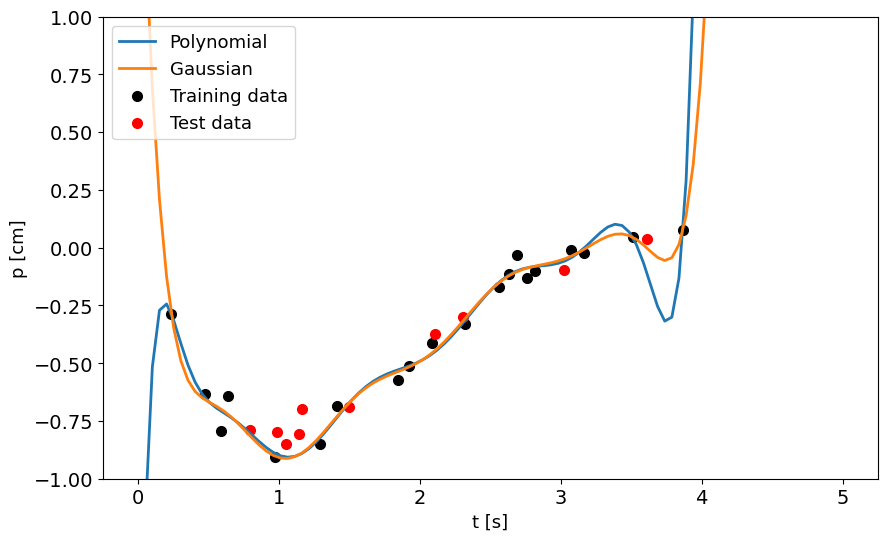

(-1.0, 1.0)

In [163]:
# plot the fit results

# ===============================================================================
# Vary the number of parameters and the standard deviation of the gaussian basis functions
# Observe the performance of the models.
# ===============================================================================

t_plot = range(0,5,length = 100)
fontsize = 13

fig = figure(figsize= (10,6))
plot(t_plot,model_poly(t_plot,result_poly)', label = "Polynomial")
plot(t_plot,model_gaussian(mus, sigma)(t_plot,result_gaussian)', label = "Gaussian")
scatter(t_train,p_train, color = "black", label = "Training data")
scatter(t_test,p_test, color = "red", label = "Test data")
xlabel("t [s]",fontsize = fontsize)
ylabel("p [cm]", fontsize = fontsize)
legend(loc = "upper left", fontsize = fontsize)

ylim(-1,1)

## Exercise 4.1d

In [164]:
# set the standard deviation of gaussian basis functions back to one
sigma = 1;

n_paras_max = 13
losses_poly_test = zeros(n_paras_max-2)
losses_poly_train = zeros(n_paras_max-2)
losses_gaussian_test = zeros(n_paras_max-2)
losses_gaussian_train = zeros(n_paras_max-2)

# ===============================================================================
# Implement a loop to test between 3 and 15 dimensional linear regression models (number of parameters) 
# Randomly initialize the initial points for newton descent in each iteration
# make sure to set the vector "mus" (mean values of the gaussian basis functions) to the lenght of (n_params - 1)

for n_params in range(3,stop=n_paras_max)
    
    # create an array of random numbers to get a starting point
    x0 = 10*rand(n_params)
    
    mus = range(minimum(t_train), maximum(t_train), length = n_params-1)
    
    result_poly,trace_poly = newton_descent(loss_train_poly,∇loss_train_poly, H_loss_train_poly,x0,maxiters = 10000, eps = 0.000000001);
    result_gaussian,trace_gaussian = newton_descent(loss_train_gaussian,∇loss_train_gaussian, H_loss_train_gaussian, x0,maxiters = 10000, eps = 0.0000001);
    
    losses_poly_test[n_params-2] = loss_test_poly(result_poly)
    losses_poly_train[n_params-2] = loss_train_poly(result_poly)
    
    losses_gaussian_test[n_params-2] = loss_test_gaussian(result_gaussian)
    losses_gaussian_train[n_params-2] = loss_train_gaussian(result_gaussian)
        
# ===============================================================================
        
end

In [165]:
losses_poly_test

11-element Vector{Float64}:
 0.1800738340181689
 0.04018654178212479
 0.03947772317929883
 0.040010336978139494
 0.03639751595900135
 0.03512206117834235
 0.03744805744693877
 0.057952131389001134
 0.06448408580253752
 0.09600841440553538
 0.5262809487443653

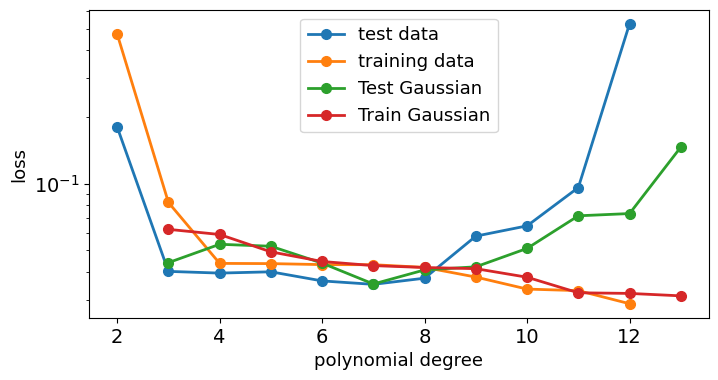

PyObject Text(28.0, 0.5, 'loss')

In [167]:
# Plot the losses versus the number of parameters
fig = figure(figsize= (8,4))
plot(range(3,stop=n_paras_max).-1,losses_poly_test, label = "test data", marker = "o")
plot(range(3,stop=n_paras_max).-1,losses_poly_train, label = "training data", marker = "o")

plot(range(3,stop=n_paras_max),losses_gaussian_test, label = "Test Gaussian", marker = "o")
plot(range(3,stop=n_paras_max),losses_gaussian_train, label = "Train Gaussian", marker = "o")

ax = plt.gca()
legend(fontsize = fontsize)
ax.set_yscale("log")

xlabel("polynomial degree", fontsize = fontsize)
ylabel("loss", fontsize = fontsize)

#ylim(3e-2,6e-2)

According to the above plot: Which number of parameters seems to be best for the respective models?

## Exercise 4.1e

In order to prevent overfitting for models with high number of model parameters, a regularization term is added to the loss function:


 \begin{equation}
l_\theta(\mathbf{x}) = \frac{1}{|D|}\sum_{i = 1}^{|D|} \left(y_i - \mathbf{\theta}^\top \mathbf{\phi}(x_i)\right)^2 + \mu \sum_{j = 1}^{n} |\theta_j|^q 
 \end{equation}

with fixed values  $\mu>0; q \geq 1; \mu, q \in \mathbb{R}$

In [62]:
using LinearAlgebra

In [63]:
# Regularization term
function regularization(θ,μ,q)
    return μ * sum(abs.(θ).^q)
end

function ∇regularization(θ,μ,q)
    n = size(θ,1)
# ===============================================================================
    # Implement the gradient of the regularization term w.r.t. θ
    gradient = μ .* q .* abs.(θ) .^ (q-1) .* sign.(θ)
# ===============================================================================
    return gradient
end

function H_regularization(θ,μ,q)
    n = size(θ,1)
    hessian = zeros(n,n)
# ===============================================================================
    # Implement the hessian of the regularization term w.r.t. θ, θ != 0 !!
    hessian[diagind(hessian, 0)] = μ .* q .* (q-1) .* abs.(θ).^(q-2) .* sign.(θ)
# ===============================================================================
    return hessian
end

H_regularization (generic function with 1 method)

In [64]:
# ===============================================================================
# try different values for the following variables
n_params = 13
q = 2
μ = 1 #  1e-3
# ===============================================================================

mus = range(minimum(t_train), maximum(t_train), length = n_params-1)



0.23545103730263994:0.33021915521451217:3.8678617446622736

In [65]:
# quadratic losses and their derivatives for polynomial linear regression model
loss_train_poly = quadratic_loss(t_train, p_train, model_poly)
∇loss_train_poly = ∇quadratic_loss(t_train, p_train, model_poly, ∇model_poly)
H_loss_train_poly = H_quadratic_loss(t_train, p_train, model_poly, ∇model_poly)

# quadratic losses and their derivatives for gaussian linear regression model
loss_train_gaussian = quadratic_loss(t_train, p_train, model_gaussian(mus, sigma))
∇loss_train_gaussian = ∇quadratic_loss(t_train, p_train, model_gaussian(mus, sigma), ∇model_gaussian(mus, sigma))
H_loss_train_gaussian = H_quadratic_loss(t_train, p_train, model_gaussian(mus, sigma), ∇model_gaussian(mus, sigma))

# Losses for test dataset
loss_test_poly = quadratic_loss(t_test, p_test, model_poly)
loss_test_gaussian = quadratic_loss(t_test, p_test, model_gaussian(mus, sigma))

(::var"#calculate_loss#14"{Vector{Float64}, Vector{Float64}, var"#calculate_model#13"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Int64}}) (generic function with 1 method)

In [66]:

loss_train_poly_reg(x) = loss_train_poly(x) + regularization(x,μ,q)
∇loss_train_poly_reg(x) = ∇loss_train_poly(x) + ∇regularization(x,μ,q)
H_loss_train_poly_reg(x) = H_loss_train_poly(x) + H_regularization(x,μ,q)

loss_train_gaussian_reg(x) = loss_train_gaussian(x) + regularization(x,μ,q)
∇loss_train_gaussian_reg(x) = ∇loss_train_gaussian(x) + ∇regularization(x,μ,q)
H_loss_train_gaussian_reg(x) = H_loss_train_gaussian(x) + H_regularization(x,μ,q)

H_loss_train_gaussian_reg (generic function with 1 method)

In [67]:
# Perform newton descent for the the regularized loss functions
using Random
Random.seed!(42);
x0 = 10*rand(n_params) # initial parameter setting
#x0 = zeros(n_params)

result_poly_reg,trace_poly_reg = newton_descent(loss_train_poly_reg,∇loss_train_poly_reg,H_loss_train_poly_reg,x0,maxiters = 10000, eps = 0.00001);

println("Minimizer: ",result_poly_reg)
println("Number of Iterations: ",size(trace_poly_reg,2))
println("Optimal loss: ",loss_train_poly_reg(result_poly_reg))
println("Gradient at Optimum: ",∇loss_train_poly_reg(result_poly_reg))

result_gaussian_reg,trace_gaussian_reg = newton_descent(loss_train_gaussian_reg,∇loss_train_gaussian_reg, H_loss_train_gaussian_reg, x0,maxiters = 10000, eps = 0.00001);

println("\n Minimizer: ",result_gaussian_reg)
println("Number of Iterations: ",size(trace_gaussian_reg,2))
println("Optimal loss: ",loss_train_gaussian_reg(result_gaussian_reg))
println("Gradient at Optimum: ",∇loss_train_gaussian_reg(result_gaussian_reg))

Minimizer: [-0.3587318357703395, -0.2576308403812537, -0.14586480223622988, -0.05530585792377285, 0.009611756087174683, 0.0429103508929245, 0.038497723564872466, 0.003854961706752036, -0.022964753197979526, 0.00040421429121817454, 0.005139285401538629, -0.0015800282882630912, 0.00014174836259694956]
Number of Iterations: 2
Optimal loss: 0.374315366477455
Gradient at Optimum: [5.254462116521808e-7, -1.1375196697915868e-6, -2.0619394848209183e-6, -4.281177605758302e-7, -2.421225892046408e-5, -3.988081659045406e-5, 0.00011003597332681636, -0.0010229891515471934, -0.0012076375550638119, 0.000711589722518724, -0.050348238446620286, -0.06345900951084382, -0.42627363595075884]

 Minimizer: [-0.04629257504751427, -0.05220383058956424, -0.11779435729529553, -0.16805693181158232, -0.1832568298208015, -0.15647061277792584, -0.09757406641630562, -0.02828091922024001, 0.028603078334246135, 0.05920021252362906, 0.06255473411410661, 0.04765282548235017, 0.02666277079301338]
Number of Iterations: 2
Op

In [68]:
# Perform newton descent for the the un-regularized loss functions

result_poly,trace_poly = newton_descent(loss_train_poly, ∇loss_train_poly, H_loss_train_poly, x0, maxiters = 10000, eps = 0.0001);
println("Minimizer: ",result_poly)
println("Number of Iterations: ",size(trace_poly,2))
println("Optimal loss: ",loss_train_poly(result_poly))
println("Loss on test data: ",loss_test_poly(result_poly))
println("Gradient at Optimum: ",∇loss_train_poly(result_poly))

result_gaussian,trace_gaussian = newton_descent(loss_train_gaussian, ∇loss_train_gaussian, H_loss_train_gaussian, x0,maxiters = 10000, eps = 0.0001);
println("\n Minimizer: ",result_gaussian)
println("Number of Iterations: ",size(trace_gaussian,2))
println("Optimal loss: ",loss_train_gaussian(result_gaussian))
println("Loss on test data: ",loss_test_gaussian(result_gaussian))
println("Gradient at Optimum: ",∇loss_train_gaussian(result_gaussian))

Minimizer: [-11.61926866764586, 150.07800771205487, -802.3849528586348, 2309.5807488856676, -4067.6456391340653, 4675.671335458879, -3635.021327583637, 1944.1215468347584, -715.8303027299066, 178.21934679498366, -28.65014952591027, 2.6836772145522914, -0.1112436965064898]
Number of Iterations: 18
Optimal loss: 0.02950809630786362
Loss on test data: 0.17568078733103829
Gradient at Optimum: [2.0388444483820933e-6, 2.100758604878239e-6, 4.080839091202826e-6, 8.473774981254678e-6, 2.6188510416691457e-5, 7.314086211618331e-5, 0.000240433401476281, 0.0008826622824216201, 0.0030809899761266024, 0.010596590518275661, 0.03920456508535608, 0.14727714753007604, 0.45971639921481255]

 Minimizer: [634.447409700014, -10228.741602440296, 35447.85833624852, -62007.869520657376, 72740.05369693517, -73415.97923323886, 74652.48843968911, -66886.31164433232, 32500.417716873755, 14868.338364339717, -40264.9615413419, 30524.82331816288, -9754.795646740085]
Number of Iterations: 2
Optimal loss: 0.03230789340

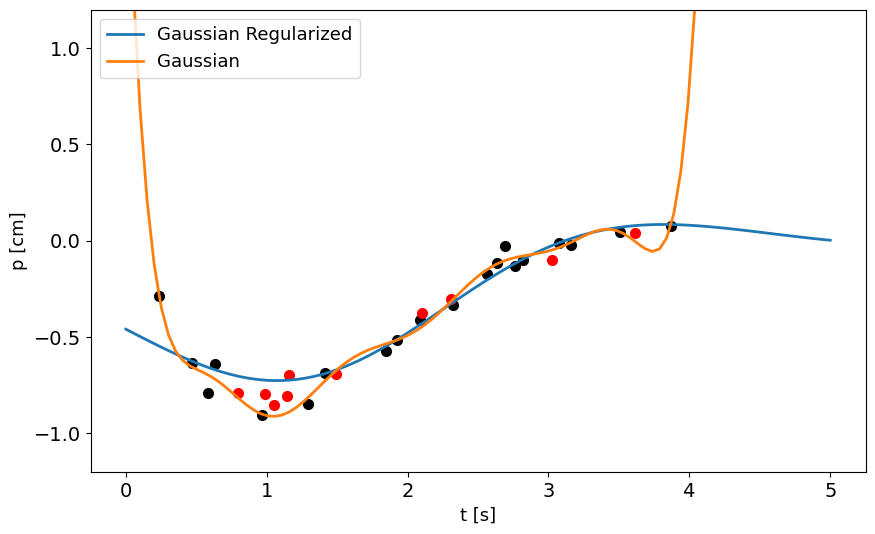

(-1.2, 1.2)

In [69]:
t_plot = range(0,5,length = 100)

fig = figure(figsize= (10,6))
#plot(t_plot,model_poly(t_plot,result_poly_reg)', label = "Polynomial Regularized")
plot(t_plot,model_gaussian(mus, sigma)(t_plot,result_gaussian_reg)', label = "Gaussian Regularized")

#plot(t_plot,model_poly(t_plot,result_poly)', label = "Polynomial")
plot(t_plot,model_gaussian(mus, sigma)(t_plot,result_gaussian)', label = "Gaussian")

scatter(t_train,p_train, color = "black")
scatter(t_test,p_test, color = "red")
xlabel("t [s]",fontsize = fontsize)
ylabel("p [cm]", fontsize = fontsize)
legend(loc = "upper left", fontsize = fontsize)

ylim(-1.2,1.2)

In [70]:
# Loop over different values for the regularization parameter μ in order to find the best one

μ_array = [1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,0.0001,0.001,0.01,0.1,1,10,100]
n_μ = size(μ_array,1)

losses_poly_test = zeros(n_μ)
losses_poly_train = zeros(n_μ)
losses_gaussian_test = zeros(n_μ)
losses_gaussian_train = zeros(n_μ)


for (index,μ) in enumerate(μ_array)
    # create an array of random numbers to get a starting point
    x0 = 10*rand(n_params)
    
    loss_train_poly_reg(x) = loss_train_poly(x) + regularization(x,μ,q)
    ∇loss_train_poly_reg(x) = ∇loss_train_poly(x) + ∇regularization(x,μ,q)
    H_loss_train_poly_reg(x) = H_loss_train_poly(x) + H_regularization(x,μ,q)

    loss_train_gaussian_reg(x) = loss_train_gaussian(x) + regularization(x,μ,q)
    ∇loss_train_gaussian_reg(x) = ∇loss_train_gaussian(x) + ∇regularization(x,μ,q)
    H_loss_train_gaussian_reg(x) = H_loss_train_gaussian(x) + H_regularization(x,μ,q)
    
    
    result_poly,trace_poly = newton_descent(loss_train_poly_reg,
                                            ∇loss_train_poly_reg,
                                            H_loss_train_poly_reg,
                                            x0,
                                            maxiters = 10000,
                                            eps = 0.0001);
    result_gaussian,trace_gaussian = newton_descent(loss_train_gaussian_reg,
                                                    ∇loss_train_gaussian_reg,
                                                    H_loss_train_gaussian_reg,
                                                    x0,
                                                    maxiters = 10000,
                                                    eps = 0.0001);
    
    losses_poly_test[index] = loss_test_poly(result_poly)
    losses_poly_train[index] = loss_train_poly(result_poly)
    
    losses_gaussian_test[index] = loss_test_gaussian(result_gaussian)
    losses_gaussian_train[index] = loss_train_gaussian(result_gaussian)
    
end

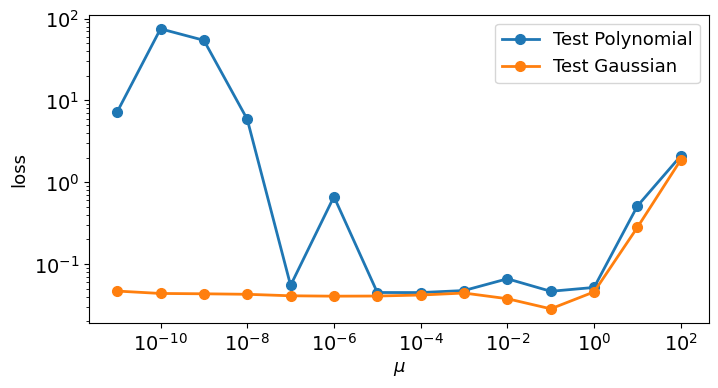

PyObject Text(28.0, 0.5, 'loss')

In [71]:
# Plot the losses on the test dataset as function of the regularization parameter μ
fig = figure(figsize= (8,4))
plot(μ_array,losses_poly_test, label = "Test Polynomial", marker = "o")
plot(μ_array,losses_gaussian_test, label = "Test Gaussian", marker = "o")

ax = plt.gca()
legend(fontsize = fontsize)
ax.set_yscale("log")
ax.set_xscale("log")

xlabel(L"$\mu$", fontsize = fontsize)
ylabel("loss", fontsize = fontsize)

#ylim(5e-3,7e-1)

# Exercise 3.3 (voluntary): Radiocarbon Dating Method

Radiocarbon dating is a good method to determine the age of archeological findings by determining the decay rate of the the radioactive carbon isotope $^{14}C$ in a given sample:
\begin{equation}
^{14}_6C \rightarrow ^{14}_7 N + e^- + \overline{\nu_e}
\end{equation}

The isotope $^{14}_6C$ is produced by cosmic radiation in the upper atmosphere:
<img src="figures/cosmic_rays.jpg" width="350">
Graphic from: https://www.kth.se/en/sci/centra/rymdcenter/utstallning/myondetektor-1.813976


Plants and animals live in an equilibrium with their surroundings in terms of their carbon content. The term "equilibrium" means in that context that the decaying isotopes are replaced by the exchange of $^{14}C$ through the atmosphere and their diets. Hence, the proportion of $^{14}C$ in the living being stays constant during its life. The **natural $^{14}C$ decay rate** in a sample of one gram of pure carbon from a **living animal** yields about $\mathbf{N_0 = 14}$ radioactive decays per minute.

Once it dies, the $^{14}C$ exchange with the environment ceases while the isotopes in its tissue will continue to decay and gradually diminish over time.
<img src="figures/C14_Kreislauf.png" width="500">
Graphic from: Von Sgbeer - Eigenes Werk, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8869328

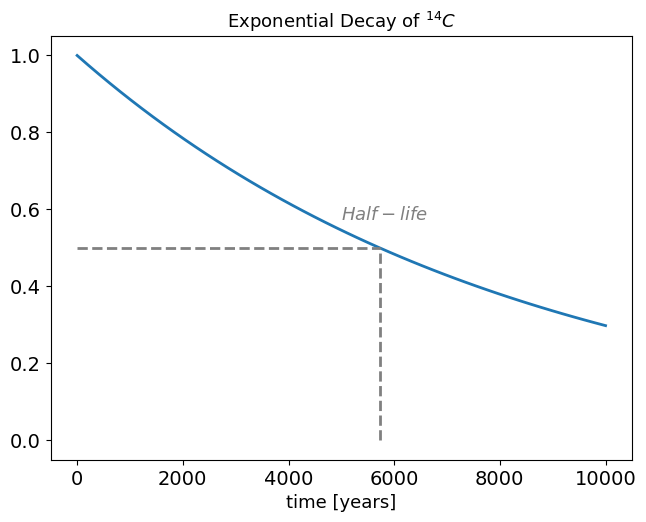

In [172]:
# exponential decay of C^14 atoms

fontsize = 13

lambda = log(2)/5730
x = range(0,10000,length = 50)
y = [exp(-k*lambda) for k = x]
plot(x,y)

xlabel("time [years]", fontsize=fontsize)
ax = gca()

plot((0,5730),(0.5,0.5),color = "gray",linestyle = "--")
plot((5730,5730),(0,0.5),color = "gray",linestyle = "--")
ax.text(0.5, 0.6, "\$Half-life\$" , transform=ax.transAxes, fontsize=fontsize, verticalalignment="top",color="gray")
ax.set_title("Exponential Decay of \$^{14}C\$",fontsize=fontsize);

Because the $^{14}C$ decays at a known rate which is exponentially decreasing over time (after 5730 years the rate will be halved), a measurement of the decay rate in a given sample can be used to determine how long the living being has been dead.

We are measuring the decays of $^{14}C$ per minute several times. Since there is only a certain probability that an atom decays within a certain time interval, the number of measured decays varies from measurement to measurement. The underlying statistics is called Poisson statistics.

The probability $p$ of measuring $x$ decays is given by
\begin{equation}
p_k(x) = \frac{k^x}{x!}e^{-k},
\end{equation}
with $k$ the expectation value which is our parameter of interest.

In [173]:
using Distributions 

# poisson distribution
p(x,k) = (k^(x)/factorial(x))*exp(-k)

p (generic function with 1 method)

## The Likelihood Function

We have a sample of archeological bones and we want to determine its age.
<img src="figures/bone.jpg" width="350">

We measure a bone piece containing one gram of natural carbon 10 times. The following array defines the observed number of decays per minute. It represents our dataset $D = \{x_1,x_2,\dots,x_n\}$:

In [174]:
data = [2, 3, 4, 6, 5, 3, 3, 5, 5, 6];

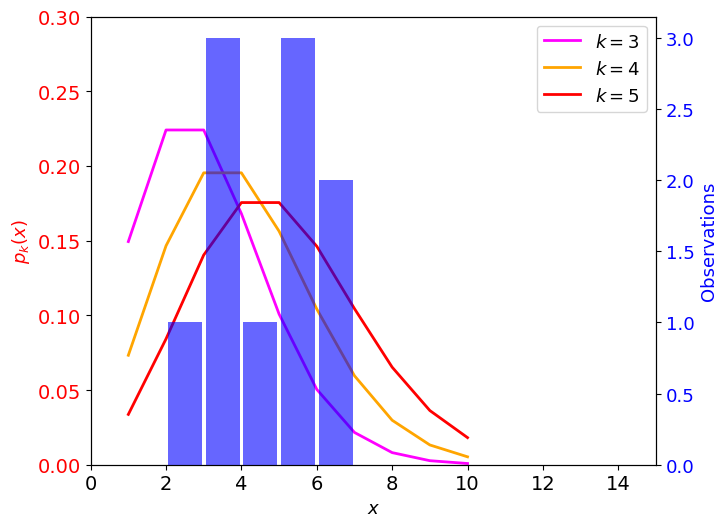

PyObject <matplotlib.legend.Legend object at 0x000001E5EE77F430>

In [183]:
# Plot the data as a histogram and compare to different Poisson distributions. Which one matches best?

test_points = range(1,10)

fig, ax1 = subplots()

# plot the poisson distributions
ax1.set_xlabel("\$x\$",fontsize=fontsize)
ax1.set_ylabel("\$p_k(x)\$", fontsize=fontsize,color = "red")

# ===============================================================================
# You can play around with the parameter k of the poisson distribution in order to find out which one is matching
# best to the data based on your eye judgement
ax1.plot(test_points,[p(x,3) for x in test_points],color = "magenta",label = "\$k = 3\$", linewidth = 2)
ax1.plot(test_points,[p(x,4) for x in test_points],color = "orange",label = "\$k = 4\$", linewidth = 2)
ax1.plot(test_points,[p(x,5) for x in test_points],color = "red",label = "\$k = 5\$", linewidth = 2)
# ===============================================================================

ax1.tick_params(axis="y", which="major", labelcolor="red")
ax1.set_ylim(0,0.3)
ax1.set_xlim(0,15)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel("Observations", color="blue",fontsize=fontsize)  # we already handled the x-label with ax1
ax2.tick_params(axis="y", which="major", labelsize=fontsize, labelcolor="blue")

# plot the dataset as a histogram
ax2.hist(data,color="blue", alpha = 0.6, rwidth = 0.9, range = (0,15), bins = 15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc = "upper right", fontsize=fontsize)

The total probability of all observations together is given by:
\begin{equation}
\ell_k(D) = \prod_i p_k(x_i)
\end{equation}
This is also called the $Likelihood\;function$. We want to find the parameter $k$ for which the likelihood of our observation is at a maximum. Hence our optimization problem is:

Maximize $\ell_k (D)$ given our dataset $D$.

Or equivalently:

Minimize $-\log \ell_k (D)$

In [184]:
function Likelihood(k)
    L = 1
    for value in data
        L = L*p(value,k)
    end
    return L
end

println(Likelihood(2))

9.760374020681735e-13


In [185]:
# ===============================================================================
# Define the negative log likelihood function
function LogLikelihood(k)
    L = 0
    for x in data
        L = L-log(p(x,k))
    end
    return L
end
# ===============================================================================

# ===============================================================================
# Define the gradient of the negative log likelihood function
function ∇LogLikelihood(k)
    L = 0
    for x in data
        L = L-(x/k-1)
    end
    return L
end
# ===============================================================================

∇LogLikelihood (generic function with 1 method)

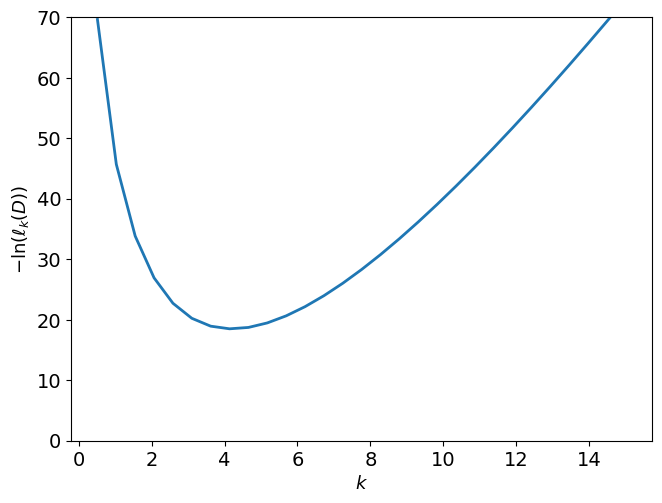

(0.0, 70.0)

In [186]:
# plot the negative Log Likelihood function versus the parameter k

test_k = range(0,15,length = 30)

# ===============================================================================
# plot the negative log likelihood function versus the parameter k

L_plot = [LogLikelihood(k) for k in test_k]
plot(test_k,L_plot)

# ===============================================================================

xlabel(L"k", fontsize=fontsize)
ylabel(L"-\mathrm{ln}\left(\ell_k(D)\right)", fontsize=fontsize)

ylim(0,70)

In [187]:
# ===============================================================================
# perform gradient descent to find the optimal k
k0 = 10;
k_best,trace = gradient_descent(LogLikelihood,∇LogLikelihood,k0);

println("Optimal loss: ",trace[end,end])
println("Gradient at optimum: ",∇LogLikelihood(k_best))
println("Iterations: ", size(trace,2))
# ===============================================================================

Optimal loss: 18.493907008806847
Gradient at optimum: -1.7763568394002505e-15
Iterations: 2


The best estimator for the number of decays per minute $\hat{k}$ in one gram of carbon is:

In [188]:
println("Best estimator: ",round(k_best, digits=2))

Best estimator: 4.2


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


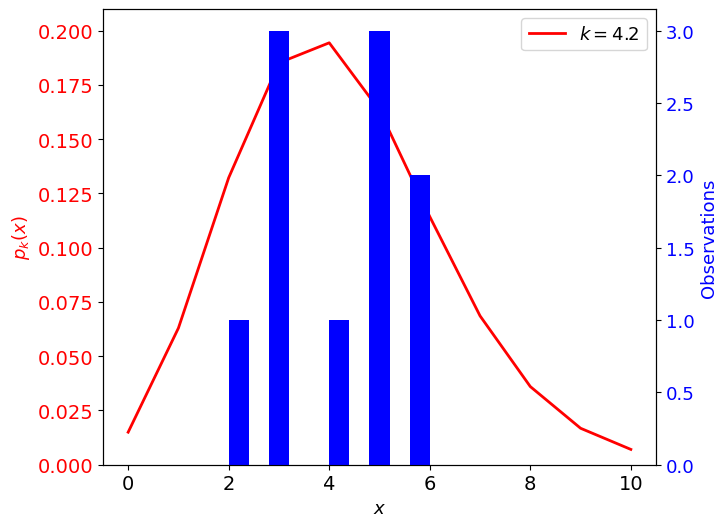

In [190]:
# show the best matching distribution together with the data

k_best = round(k_best, digits=2)

test_points = range(0,10)
y = [p(x,k_best) for x in test_points]

fig, ax1 = subplots()

ax1.set_xlabel(L"$x$",fontsize=fontsize)
ax1.set_ylabel(L"$p_k(x)$", fontsize=fontsize,color = "red")
ax1.plot(test_points,y,color = "red",label = "\$k = $k_best\$")
ax1.tick_params(axis="y", which="major", labelcolor="red")
ax1.set_ylim(0,0.21)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Observations", color="blue",fontsize=fontsize)  # we already handled the x-label with ax1
ax2.tick_params(axis="y", which="major", labelsize=fontsize, labelcolor="blue")
ax2.hist(data,color="blue")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc = "upper right", fontsize=fontsize)
show()

The natural decay rate in a sample of one gram of pure carbon from a living animal should produce about $x_0 = 14$ radioactive decays per minute. This number is exponentially reduced after the death of the living being since no carbon is incorporated into the tissue any more.

The age of the sample in years is given by (derived from the kown half-life and the exponential decay function):
\begin{equation}
    a=8267\cdot \ln\frac{x_{0}}{\hat{k}}
\end{equation}

with $\hat{k}$ the value that minimizes $-\log \ell_k (D)$.

In [191]:
# ===============================================================================
# Calculate the age of the archeological artefact

x0 = 14
age = 8267 * log(x0/k_best)
# ===============================================================================

println(round(age, digits=2)," years")

9953.24 years


Neolithic age:
<img src="figures/BildJungsteinzeit.png" width="500">